In [ ]:
import pandas as pd
import requests 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np


In [ ]:
ticker = input("digit o ticker: ")
url = f"https://finance.yahoo.com/quote/{ticker}.SA/history/?period1=1590516222&period2=1748282618"
table_att = ['Data', 'Abertura', 'Máxima', 'Mínima', 'Fechamento', 'Volume']

def extract(url, table_att):
    """
    Função para extrair a tabela com as informações
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/115.0 Safari/537.36"
    }
    
    html_page = requests.get(url, headers=headers).text
    data = BeautifulSoup(html_page, "html.parser")
    df = pd.DataFrame(columns=table_att)

    table = data.find_all('tbody')
    rows = table[0].find_all('tr')

    for row in rows:
        column = row.find_all('td')
        if len(column) == 7: # no site cada linha da table tem exatamente 7 colunas
            date_text = column[0].text.strip()
            try:
                # Tentar converter a data para garantir que é uma data válida
                datetime.strptime(date_text, '%b %d, %Y')
            except ValueError:
                # Se não for data válida, pula a linha
                continue
            data_dict = {'Data': column[0].text.strip(), 'Abertura': column[1].text.strip(), 'Máxima': column[2].text.strip()
                        , 'Mínima': column[3].text.strip(), 'Fechamento': column[4].text.strip(), 'Volume': column[6].text.strip()}
            df2 = pd.DataFrame(data_dict, index = [0])
            df = pd.concat([df, df2], ignore_index=True)
            df['Data'] = pd.to_datetime(df['Data'], format='%b %d, %Y', errors='coerce')

    return df

print(extract(url=url, table_att=table_att))
    

df = extract(url, table_att)
df.head(10)


digit o ticker:  ITUB4


           Data Abertura Máxima Mínima Fechamento      Volume
0    2025-05-26    37.62  38.25  37.54      37.81   4,191,600
1    2025-05-23    36.60  37.72  36.36      37.72  20,125,900
2    2025-05-22    37.64  37.74  37.14      37.27  22,889,800
3    2025-05-21    38.19  38.20  37.22      37.53  20,216,400
4    2025-05-20    38.38  38.38  37.86      38.30  17,978,200
...         ...      ...    ...    ...        ...         ...
1239 2020-06-01    20.75  21.68  20.64      21.51  43,143,430
1240 2020-05-29    21.07  21.18  20.65      20.95  59,365,350
1241 2020-05-28    21.35  21.86  21.19      21.19  26,310,350
1242 2020-05-27    21.49  21.57  21.05      21.57  40,084,110
1243 2020-05-26    22.12  22.20  20.78      20.92  58,373,590

[1244 rows x 6 columns]


,Data,Abertura,Máxima,Mínima,Fechamento,Volume
0,2025-05-26,37.62,38.25,37.54,37.81,"4,193,600"
1,2025-05-23,36.60,37.72,36.36,37.72,"20,125,900"
2,2025-05-22,37.64,37.74,37.14,37.27,"22,889,800"
3,2025-05-21,38.19,38.20,37.22,37.53,"20,216,400"
4,2025-05-20,38.38,38.38,37.86,38.30,"17,978,200"
5,2025-05-19,37.82,38.59,37.71,38.35,"24,323,000"
6,2025-05-16,37.68,38.00,37.37,37.90,"29,635,800"
7,2025-05-15,37.36,37.77,37.22,37.68,"26,350,700"
8,2025-05-14,36.94,37.34,36.81,37.18,"17,869,500"
9,2025-05-13,36.68,37.11,36.52,36.93,"24,635,200"


In [ ]:
def transform(df):
    df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
    
    for col in ['Abertura', 'Máxima', 'Mínima', 'Fechamento']:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace(',', '').str.strip()  # Remove vírgulas e espaços
            df[col] = pd.to_numeric(df[col], errors='coerce')   # Converte para float, valores inválidos viram NaN
        else:
            df[col] = df[col].astype(float)

    
    # Tratar o Volume
    df['Volume'] = df['Volume'].replace('-', np.nan)
    if df['Volume'].dtype == 'object':
        df['Volume'] = df['Volume'].str.replace(',', '')
        df['Volume'] = df['Volume'].fillna('0').astype(int)
    else:
        df['Volume'] = df['Volume'].astype(int)

    # Médias móveis exponenciais
    df['Ema_10'] = df['Fechamento'].ewm(span=10, adjust=False).mean()
    df['Ema_50'] = df['Fechamento'].ewm(span=50, adjust=False).mean()
    df['Ema_200'] = df['Fechamento'].ewm(span=200, adjust=False).mean()

    return df


df = transform(df)
df.head(10)


,Data,Abertura,Máxima,Mínima,Fechamento,Volume,Ema_10,Ema_50,Ema_200
0,2025-05-26,37.62,38.25,37.54,37.81,4193600,37.810000,37.810000,37.810000
1,2025-05-23,36.60,37.72,36.36,37.72,20125900,37.793636,37.806471,37.809104
2,2025-05-22,37.64,37.74,37.14,37.27,22889800,37.698430,37.785433,37.803740
3,2025-05-21,38.19,38.20,37.22,37.53,20216400,37.667806,37.775416,37.801016
4,2025-05-20,38.38,38.38,37.86,38.30,17978200,37.782750,37.795988,37.805981
5,2025-05-19,37.82,38.59,37.71,38.35,24323000,37.885887,37.817713,37.811395
6,2025-05-16,37.68,38.00,37.37,37.90,29635800,37.888453,37.820940,37.812276
7,2025-05-15,37.36,37.77,37.22,37.68,26350700,37.850552,37.815413,37.810960
8,2025-05-14,36.94,37.34,36.81,37.18,17869500,37.728634,37.790495,37.804682
9,2025-05-13,36.68,37.11,36.52,36.93,24635200,37.583428,37.756750,37.795979


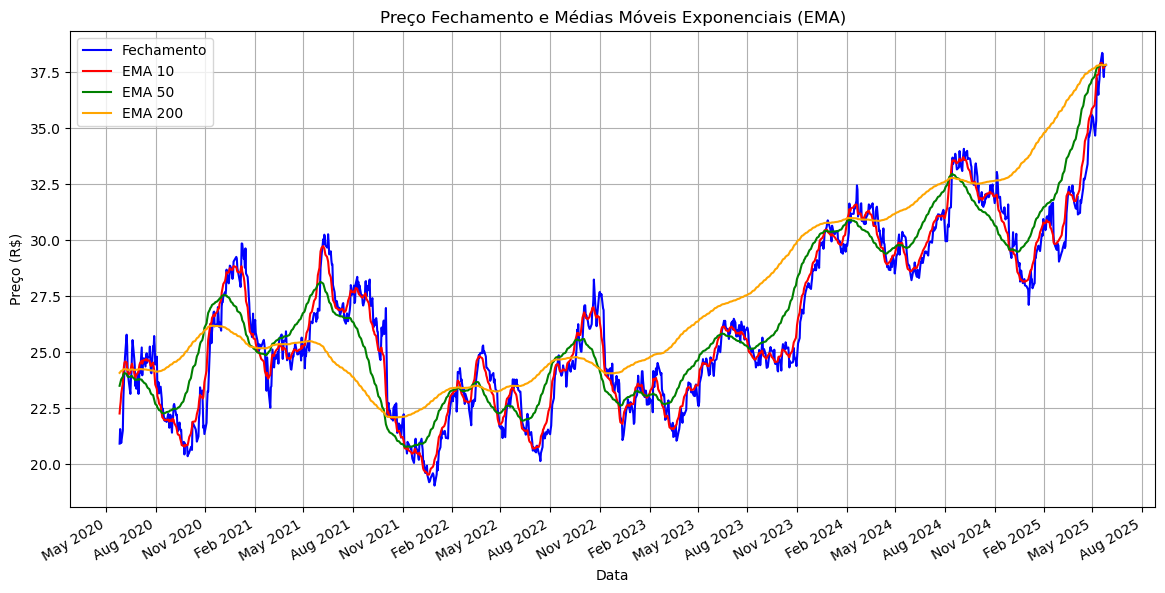

In [ ]:
import matplotlib.dates as mdates

data_max = df['Data'].max()
data_min = data_max - pd.DateOffset(years=5)
df_plot = df[(df['Data'] >= data_min) & (df['Data'] <= data_max)]


plt.figure(figsize=(14,7))

plt.plot(df_plot['Data'], df_plot['Fechamento'], label='Fechamento', color='blue')
plt.plot(df_plot['Data'], df_plot['Ema_10'], label='EMA 10', color='red')
plt.plot(df_plot['Data'], df_plot['Ema_50'], label='EMA 50', color='green')
plt.plot(df_plot['Data'], df_plot['Ema_200'], label='EMA 200', color='orange')

plt.title('Preço Fechamento e Médias Móveis Exponenciais (EMA)')
plt.xlabel('Data')
plt.ylabel('Preço (R$)')
plt.legend()
plt.grid(True)

# Ajuste do eixo X para mostrar datas legíveis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # a cada 3 meses
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()  # rotaciona datas

plt.savefig(f'Dados_Historicos_{ticker}.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def salvar(df, ticker):
    filename = f"{ticker}_dados.csv"  # nome do arquivo com o ticker
    df.to_csv(filename, index=False)  # salva sem o índice
    print(f"Arquivo salvo como {filename}")


salvar(df, ticker)

Arquivo salvo como ITUB4_dados.csv
